# Cargue de datos s SciDB
## 1) Verificar Prerequisitos
### Python
SciDB-Py requires Python 2.6-2.7 or 3.3

In [1]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=4, micro=3, releaselevel='final', serial=0)

### NumPy
tested with version 1.9 (1.13.1)

In [2]:
import numpy
numpy.__version__

'1.13.1'

### Requests
tested with version 2.7 (2.18.1) Required for using the Shim interface to SciDB.

In [3]:
import requests
requests.__version__

'2.18.3'

### Pandas (optional)
tested with version 0.15. (0.20.3) Required only for importing/exporting SciDB arrays as Pandas Dataframe objects.

In [4]:
import pandas as pd
pd.__version__

'0.20.3'

### SciPy (optional)
tested with versions 0.10-0.12. (0.19.0) Required only for importing/exporting SciDB arrays as SciPy sparse matrices.

In [5]:
import scipy
scipy.__version__

'0.19.1'

## 2) Importar scidbpy
pip install git+http://github.com/paradigm4/scidb-py.git@devel

In [6]:
import scidbpy
scidbpy.__version__

'16.9'

In [7]:
from scidbpy import connect

conectarse al servidor de Base de datos

In [8]:
sdb = connect('http://localhost:8080')

## 3) Leer archivo con cada una de las ondas

In [9]:
import urllib.request  # urllib2 in python2 the lib that handles the url stuff
target_url = "https://www.physionet.org/physiobank/database/mimic2wdb/matched/RECORDS-waveforms"
data = urllib.request.urlopen(target_url) # it's a file like object and works just like a file

In [10]:
lines = data.readlines();
line = str(lines[0])

Quitarle caracteres especiales

In [11]:
carpeta,onda = line.replace('b\'','').replace('\'','').replace('\\n','').split("/")
onda

's00001-2896-10-09-01-56'

## 4) Importar WFDB para conectarse a physionet

In [12]:
import wfdb

In [13]:
sig, fields = wfdb.srdsamp(onda,pbdir='mimic2wdb/matched/'+carpeta) #, sampfrom=11000

In [14]:
print(sig)
print("signame: " + str(fields['signame']))
print("units: " + str(fields['units']))
print("fs: " + str(fields['fs']))
print("comments: " + str(fields['comments']))
print("fields: " + str(fields))

[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 ..., 
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
signame: ['II', 'V', 'MCL1', 'ABP']
units: ['mV', 'mV', 'mV', 'mmHg']
fs: 125
comments: ['<age>: 60 <sex>: F']
fields: {'signame': ['II', 'V', 'MCL1', 'ABP'], 'units': ['mV', 'mV', 'mV', 'mmHg'], 'fs': 125, 'comments': ['<age>: 60 <sex>: F']}


Busca la ubicacion de la señal tipo II 

In [15]:
signalII = None
try:
    signalII = fields['signame'].index("II")
except ValueError:
    print("List does not contain value")
if(signalII!=None):
    print("List contain value")

List contain value


Normaliza la señal y le quita los valores en null

In [16]:
array = wfdb.processing.normalize(x=sig[:, signalII], lb=-2, ub=2)
arrayNun = array[~numpy.isnan(array)]
arrayNun
#array = array.reshape(-1, 1)

array([], dtype=float64)

Cambiar los guiones "-" por raya al piso "_" porque por algun motivo SciDB tiene problemas con estos caracteres
Si el arreglo sin valores nulos no queda vacio lo sube al SciDB

In [17]:
ondaName = onda.replace("-", "_")
if arrayNun.size>0 :
    sdb.input(upload_data=array).store(ondaName,gc=False)
#    sdb.iquery("store(input(<x:int64>[i], '{fn}', 0, '{fmt}'), "+ondaName+")", upload_data=array)

lista de los arreglos que actualmente se encuentran en SciDB

In [18]:
dir(sdb.arrays)

['s00001_2896_10_10_00_31',
 's00020_2567_03_30_17_47',
 's00033_2559_01_25_12_35',
 's00033_2559_01_26_13_11',
 's00052_3036_03_14_02_21',
 's00076_3103_08_06_18_45',
 's00079_2756_08_14_01_25',
 's00079_2756_08_14_12_28',
 's00123_2772_11_02_03_01',
 's00123_2772_11_03_12_58',
 's00124_3297_08_04_15_23',
 's00124_3297_08_12_01_20',
 's00135_2909_04_11_10_04',
 's00138_2817_11_01_13_39',
 's00151_2509_04_12_15_19',
 's00151_2509_04_15_12_12',
 's00151_2509_04_16_14_43',
 's00177_3299_12_03_12_35',
 's00194_2675_05_03_14_34',
 's00208_2955_05_18_00_06',
 's00214_3084_11_28_16_23',
 's00214_3084_12_02_22_02',
 's00217_2669_08_23_12_28',
 's00262_2554_11_12_18_06',
 's00263_2931_11_13_23_52',
 's00263_2931_11_15_19_57',
 's00263_2931_11_16_11_58',
 's00279_3271_08_20_21_22',
 's00283_2948_10_24_13_16',
 's00302_3023_04_11_23_00',
 's00302_3023_04_13_12_27',
 's00308_2915_08_04_12_57',
 's00308_2915_08_28_04_22',
 's00317_3234_10_03_15_24',
 's00318_3031_08_09_07_15',
 's00368_2568_06_23_

Borra todos los arreglos de la base de datos.

#for line in dir(sdb.arrays):
#    sdb.iquery('remove('+line+')')

Obtiene el arreglo s00515_3148_06_10_10_44 de SciDB

In [20]:
myArray = sdb.iquery('scan(s00600_3152_10_19_18_13)', fetch=True, as_dataframe=True)

Imprime el contenido del arreglo

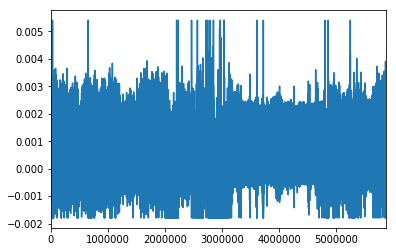

In [21]:
import matplotlib.pyplot as plt
simpleArray = myArray["x"];
#simpleArray = numpy.trim_zeros(simpleArray)
simpleArray.plot()
plt.show()

In [22]:
simpleArray

0         -0.001793
1         -0.001793
2         -0.001793
3         -0.001793
4         -0.001793
5         -0.001793
6         -0.001793
7         -0.001793
8         -0.001793
9         -0.001793
10        -0.001793
11        -0.001793
12        -0.001793
13        -0.001793
14        -0.001793
15        -0.001793
16        -0.001793
17        -0.001793
18        -0.001793
19        -0.001793
20        -0.001793
21        -0.001793
22        -0.001793
23        -0.001793
24        -0.001793
25        -0.001793
26        -0.001793
27        -0.001793
28        -0.001793
29        -0.001793
             ...   
5865202   -0.000253
5865203   -0.000288
5865204   -0.000267
5865205   -0.000267
5865206   -0.000232
5865207   -0.000267
5865208   -0.000267
5865209   -0.000232
5865210   -0.000253
5865211   -0.000302
5865212   -0.000267
5865213   -0.000267
5865214   -0.000267
5865215   -0.000288
5865216   -0.000267
5865217   -0.000232
5865218   -0.000267
5865219   -0.000253
5865220   -0.000267


Lee el contenido del archivo donde se encuentran las ondas ya leidas

In [23]:
file = open("readedWaves.txt","r")    
arrays = dir(sdb.arrays)
filelines = file.readlines()
arrays.extend([w.replace('\n','') for w in filelines])
#type(arrays)
arrays

['s00001_2896_10_10_00_31',
 's00020_2567_03_30_17_47',
 's00033_2559_01_25_12_35',
 's00033_2559_01_26_13_11',
 's00052_3036_03_14_02_21',
 's00076_3103_08_06_18_45',
 's00079_2756_08_14_01_25',
 's00079_2756_08_14_12_28',
 's00123_2772_11_02_03_01',
 's00123_2772_11_03_12_58',
 's00124_3297_08_04_15_23',
 's00124_3297_08_12_01_20',
 's00135_2909_04_11_10_04',
 's00138_2817_11_01_13_39',
 's00151_2509_04_12_15_19',
 's00151_2509_04_15_12_12',
 's00151_2509_04_16_14_43',
 's00177_3299_12_03_12_35',
 's00194_2675_05_03_14_34',
 's00208_2955_05_18_00_06',
 's00214_3084_11_28_16_23',
 's00214_3084_12_02_22_02',
 's00217_2669_08_23_12_28',
 's00262_2554_11_12_18_06',
 's00263_2931_11_13_23_52',
 's00263_2931_11_15_19_57',
 's00263_2931_11_16_11_58',
 's00279_3271_08_20_21_22',
 's00283_2948_10_24_13_16',
 's00302_3023_04_11_23_00',
 's00302_3023_04_13_12_27',
 's00308_2915_08_04_12_57',
 's00308_2915_08_28_04_22',
 's00317_3234_10_03_15_24',
 's00318_3031_08_09_07_15',
 's00368_2568_06_23_